In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shutil
import numpy as np
import glob
import random
from tqdm import tqdm
import cv2
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/dataset.zip" -d "/content/sample_data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Archive:  /content/drive/My Drive/dataset.zip
   creating: /content/sample_data/sample_data/dataset/
   creating: /content/sample_data/sample_data/dataset/women/
  inflating: /content/sample_data/sample_data/dataset/women/female568.jpg  
  inflating: /content/sample_data/sample_data/dataset/women/female1351.jpg  
  inflating: /content/sample_data/sample_data/dataset/women/female608.jpg  
  inflating: /content/sample_data/sample_data/dataset/women/female1210.jp

In [ ]:
class AddGaussianNoise(object):
    def __init__(self,mean=0,std=1):
        self.mean=mean
        self.std=std
    
    def __call__(self,image):
        image=image.numpy()
        noise =  np.random.normal(loc=self.mean, scale=self.std, size=image.shape)
        noisy = np.clip((image + noise*0.2),0,1)
        noisy=torch.from_numpy(noisy)
        return noisy
    def __repr__(self):
         return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
        

In [ ]:
## IMPORTANT INIT
use_gpu = torch.cuda.is_available()
print(use_gpu)
MEAN,STD=0,1 #To be used in gaussian noise
DIM=224 # shape of image
PROB_NOISE=0.4 # probability of gaussian noise

batch_size = 128
validation_split = .2
shuffle_dataset = True
random_seed= 42

LEARNING_RATE=0.001

EPOCHS=7

True


In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
    transforms.RandomApply([AddGaussianNoise(MEAN,STD)],p=PROB_NOISE)
])

In [ ]:
def check_acc(cnn,data_loader):
    num_correct,num_sample = 0, 0
    for images,labels in data_loader:
        if use_gpu:
            images = images.cuda()
            labels = labels.cuda()
        outputs = cnn(images)

        _,pred = torch.max(outputs.data,1)
        num_sample += labels.size(0)
        num_correct += (pred == labels).sum()
    return float(num_correct)/num_sample

In [ ]:
def plot_performance_curves(train_acc_history,val_acc_history,epoch_history):
    plt.figure()
    plt.plot(np.array(epoch_history),np.array(train_acc_history),label = 'Training accuracy')
    plt.plot(np.array(epoch_history),np.array(val_acc_history),label = 'Validation accuracy')
    plt.title('Accuracy on training and validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of epochs')
    plt.legend()
    plt.show()

In [ ]:
def save_checkpoint(state,is_best,file_name = '/content/sample_data/checkpoint.pth.tar'):
    torch.save(state,file_name)
    if is_best:
        shutil.copyfile(file_name,'model_best.pth.tar')

In [ ]:
l=glob.glob("/content/sample_data/sample_data/dataset"+"/*/*")
del l[:2],l[-2:]
for i in l:
  print(i.split('/')[5])

women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
women
wome

In [ ]:
class DatasetGender(torch.utils.data.Dataset):
    def __init__(self,path="../input/men-women-classification",transform=None):
        self.path=path
        list_of_images=glob.glob(path+"/*/*")
        del list_of_images[:2]
        del list_of_images[-2:]
        
        [list_of_images.remove(i) for i in list_of_images if i.split('/')[-1].split('.')[1]=='gif']
        random.shuffle(list_of_images)
        #list_of_images=[i for i in list_of_images_sample if i.split('/')[-1].split('.')[1]!='gif']
        self.list_of_images=list_of_images
        self.transform=transform
    def __len__(self):
        return len(self.list_of_images)
    
    def __getitem__(self,idx):
        image_path=self.list_of_images[idx]
        image=cv2.imread(image_path)
        # try:
        #     face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        #     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #     faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        #     if len(faces) > 0:
        #         (x, y, w, h) = faces[0]
        #         ROI = image[y-25:y+h, x:x+w]
        
        #     image=cv2.resize(ROI,(DIM,DIM))
        #     image=cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        # except:
        #     image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #     image=cv2.resize(image,(DIM,DIM))

        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,(DIM,DIM))
        label=image_path.split('/')[5]
        ## if colab use 4 else 3
        label_op=0 if label=='men' else 1
        
        if self.transform:
            image=self.transform(image)
        return (image.double(),label_op)
        

In [ ]:
# For testing
tst=DatasetGender(path="/content/sample_data/sample_data/dataset",transform=transform)
tit=iter(tst)

1


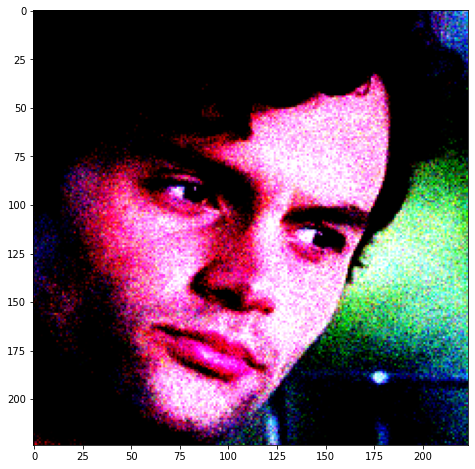

In [ ]:
img,l=next(tit)
img.shape
i=img.numpy()
i=np.transpose(i,(1,2,0))
plt.figure(figsize=(8,8))
plt.imshow(i,cmap='gray')
print(l)

In [ ]:
data=DatasetGender(transform=transform,path="/content/sample_data/sample_data/dataset")
# Creating data indices for training and validation splits:
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
train_l=iter(train_loader)
images, labels = train_l.next()
print(labels.unique())

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))


tensor([0, 1])
images shape on batch size = torch.Size([128, 3, 224, 224])
labels shape on batch size = torch.Size([128])


In [ ]:
model=models.resnet34(pretrained=True)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
for p in model.parameters():
    p.requires_grad = False

In [ ]:
model.fc=nn.Sequential(nn.Linear(512,1000),nn.LeakyReLU(0.2),nn.Linear(1000, 1200),nn.LeakyReLU(0.2),nn.Linear(1200, 1250),nn.LeakyReLU(0.2),nn.Linear(1250, 1350),nn.BatchNorm1d(1350), nn.ReLU(), nn.Linear(1350, 1400),nn.LeakyReLU(0.2),nn.Linear(1400,1600),nn.BatchNorm1d(1600),nn.ReLU(), nn.Linear(1600,2))

In [ ]:
# model=model.double().cuda()
# model(img.view(1,3,224,224).double().cuda())

In [ ]:
def train_model(model,optimizer,crit,num_epochs=100):
    '''Parameters: Model , optimizer, loss function , num of epochs'''
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    epoch_history = []
    best_val_acc = 0.0
    model=model.double()
    if use_gpu:
        print("Model using GPU")
        model=model.cuda()
    for epoch in range(num_epochs):
        model.train()
        for i,(images,labels) in tqdm(enumerate(train_loader)):
            if use_gpu:
                images,labels = images.double().cuda(),labels.cuda()
            model.zero_grad()
            optimizer.zero_grad()
            pred_labels = model(images)
            
            loss = crit(pred_labels,labels)
            
            loss.backward()
            optimizer.step()

            if (i+1) % 5 == 0:
                print ('Epoch [%d/%d], Iter [%d] Loss: %.6f' 
                    %(epoch+1, num_epochs, i+1, loss.item()))

        #if epoch % 10 ==0 or epoch == num_epochs-1:

        train_acc = check_acc(model,train_loader)
        train_acc_history.append(train_acc)
        print('Train accuracy for epoch {}: {} '.format(epoch + 1,train_acc))
        model.eval()
        val_acc = check_acc(model,validation_loader)
        val_acc_history.append(val_acc)
        print('Validation accuracy for epoch {} : {} '.format(epoch + 1,val_acc))
        epoch_history.append(epoch+1)
        
        is_best = val_acc > best_val_acc
        best_val_acc = max(val_acc,best_val_acc)
        save_checkpoint(
            {'epoch':epoch+1,
            'state_dict':model.state_dict(),
            'best_val_acc':best_val_acc,
            'optimizer':optimizer.state_dict()},is_best)

    plot_performance_curves(train_acc_history,val_acc_history,epoch_history)


In [ ]:
optimizer=torch.optim.SGD(model.parameters(),lr=LEARNING_RATE)
crit=nn.CrossEntropyLoss()
# train_model(model,optimizer,crit,EPOCHS)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = F"/content/gdrive/My Drive/resnet34UsingSGD_final.pt"

In [ ]:
model.load_state_dict(torch.load(path))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.fc[14]

Linear(in_features=1600, out_features=2, bias=True)

In [ ]:
for p in model.parameters():
    p.requires_grad = False

In [ ]:
model.fc[14]=nn.Sequential(nn.Linear(1600,120), nn.ReLU(), nn.Linear(120, 2))

0it [00:00, ?it/s]

Model using GPU


5it [00:38,  9.16s/it]

Epoch [1/7], Iter [5] Loss: 0.433374


10it [01:16,  9.36s/it]

Epoch [1/7], Iter [10] Loss: 0.277469


15it [01:53,  9.42s/it]

Epoch [1/7], Iter [15] Loss: 0.209107


20it [02:31,  9.42s/it]

Epoch [1/7], Iter [20] Loss: 0.253387


21it [02:32,  7.24s/it]


Train accuracy for epoch 1: 0.9050680786686838 
Validation accuracy for epoch 1 : 0.903177004538578 


5it [00:37,  8.00s/it]

Epoch [2/7], Iter [5] Loss: 0.156071


10it [01:15,  9.18s/it]

Epoch [2/7], Iter [10] Loss: 0.132678


15it [01:52,  9.38s/it]

Epoch [2/7], Iter [15] Loss: 0.233651


20it [02:30,  9.40s/it]

Epoch [2/7], Iter [20] Loss: 0.207589


21it [02:30,  7.18s/it]


Train accuracy for epoch 2: 0.9247352496217852 
Validation accuracy for epoch 2 : 0.913767019667171 


5it [00:37,  8.02s/it]

Epoch [3/7], Iter [5] Loss: 0.146421


10it [01:15,  9.19s/it]

Epoch [3/7], Iter [10] Loss: 0.124382


15it [01:52,  9.37s/it]

Epoch [3/7], Iter [15] Loss: 0.233375


20it [02:30,  9.41s/it]

Epoch [3/7], Iter [20] Loss: 0.162818


21it [02:30,  7.19s/it]


Train accuracy for epoch 3: 0.8831316187594553 
Validation accuracy for epoch 3 : 0.8850226928895613 


5it [00:37,  7.99s/it]

Epoch [4/7], Iter [5] Loss: 0.153804


10it [01:15,  9.18s/it]

Epoch [4/7], Iter [10] Loss: 0.150574


15it [01:52,  9.38s/it]

Epoch [4/7], Iter [15] Loss: 0.314323


20it [02:30,  9.41s/it]

Epoch [4/7], Iter [20] Loss: 0.510859


21it [02:30,  7.18s/it]


Train accuracy for epoch 4: 0.9239788199697428 
Validation accuracy for epoch 4 : 0.9107413010590015 


5it [00:37,  7.98s/it]

Epoch [5/7], Iter [5] Loss: 0.226503


10it [01:15,  9.18s/it]

Epoch [5/7], Iter [10] Loss: 0.185605


15it [01:52,  9.38s/it]

Epoch [5/7], Iter [15] Loss: 0.156692


20it [02:30,  9.41s/it]

Epoch [5/7], Iter [20] Loss: 0.214177


21it [02:30,  7.17s/it]


Train accuracy for epoch 5: 0.93267776096823 
Validation accuracy for epoch 5 : 0.9485627836611196 


5it [00:37,  7.99s/it]

Epoch [6/7], Iter [5] Loss: 0.134750


10it [01:15,  9.18s/it]

Epoch [6/7], Iter [10] Loss: 0.172855


15it [01:52,  9.37s/it]

Epoch [6/7], Iter [15] Loss: 0.202994


20it [02:30,  9.41s/it]

Epoch [6/7], Iter [20] Loss: 0.122023


21it [02:30,  7.18s/it]


Train accuracy for epoch 6: 0.9387291981845688 
Validation accuracy for epoch 6 : 0.9364599092284418 


5it [00:37,  7.99s/it]

Epoch [7/7], Iter [5] Loss: 0.144743


10it [01:15,  9.18s/it]

Epoch [7/7], Iter [10] Loss: 0.240712


15it [01:52,  9.38s/it]

Epoch [7/7], Iter [15] Loss: 0.230016


20it [02:30,  9.41s/it]

Epoch [7/7], Iter [20] Loss: 0.173758


21it [02:30,  7.17s/it]


Train accuracy for epoch 7: 0.943267776096823 
Validation accuracy for epoch 7 : 0.9273827534039334 


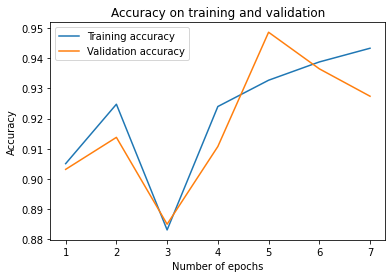

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)
crit=nn.CrossEntropyLoss()
train_model(model,optimizer,crit,EPOCHS)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model_save_name = 'resnet34UsingSGD_final.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture('/content/li2.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, 1.1, 8)

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w+20, y+h+20), (255, 0, 0), 2)
            ROI = frame[y-25:y+h, x:x+w]
            frame = cv2.resize(ROI,(224,224))
            frame=transform(frame)
            frame = torch.tensor(frame)
            frame=torch.unsqueeze(frame, 0)
            frame = frame.float().cuda()
            model=model.cuda()
            outputs=model(frame)
            _,pred = torch.max(outputs.data,1)

            font = cv2.FONT_HERSHEY_SIMPLEX 
            org = (x, y+h+45) 
            fontScale = 1
            color = (0, 0, 255)
            thickness = 2
            frame = cv2.putText(frame, str(pred), org, font, fontScale, color, thickness, cv2.LINE_AA)
        
        out.write(frame)

        cv2_imshow(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


TypeError: ignored